khadeeja shah
21i 1653
deep learning
assignment 2
question 1

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim



Image Compression and Reconstruction using Custom Neural Networks

1. Data Exploration and preprocessing

In [2]:

def loaddata(org, comp):
    orgimg = []
    compimg = []

    for filename in os.listdir(org):  # refimgs
        if filename.endswith(('.bmp')): # because images are only in bmp.
            orgimg.append(filename)  

    for folder in comp:
        for filename in os.listdir(folder):  # all qf folders.
            if filename.endswith(('.bmp')):
                paths = os.path.join(folder, filename) 
                compimg.append(paths)

    return orgimg, compimg

In [3]:
def makingpairs(orgimg, compimg, idx, f):

    paths = os.path.join(f, orgimg[idx])
    orgimgs = Image.open(paths).convert('RGB') # to make sure all are rgb always

    paths2 = compimg[idx % len(compimg)]
    compimgs = Image.open(paths2).convert('RGB')

    # this will make pairs and output will be like:
    #
    print(f"Original image: {orgimg[idx]} is paired with qf folder image: {os.path.basename(paths2)}")

    return orgimgs, compimgs


In [4]:
# for transformTIONS we are only doing resize and convert into numbers 
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),           
])

org = 'q2/refimgs'
com = ['q2/qf10']#, 'q2/qf20', 'q2/qf30', 'q2/qf40', 'q2/qf50', 'q2/qf60', 'q2/qf70', 'q2/qf80', 'q2/qf90']

ogs, comps = loaddata(org, com)

# we are making pairs here - in tensor
image_pairs = []
for idx in range(len(ogs)):
    o, c = makingpairs(ogs, comps, idx, org)
    o = transform(o) 
    c = transform(c) 
    image_pairs.append((o, c))

train_loader = DataLoader(image_pairs, batch_size=32, shuffle=True)


Original image: bikes.bmp is paired with qf folder image: bikes.bmp
Original image: building2.bmp is paired with qf folder image: building2.bmp
Original image: buildings.bmp is paired with qf folder image: buildings.bmp
Original image: caps.bmp is paired with qf folder image: caps.bmp
Original image: carnivaldolls.bmp is paired with qf folder image: carnivaldolls.bmp
Original image: cemetry.bmp is paired with qf folder image: cemetry.bmp
Original image: churchandcapitol.bmp is paired with qf folder image: churchandcapitol.bmp
Original image: coinsinfountain.bmp is paired with qf folder image: coinsinfountain.bmp
Original image: dancers.bmp is paired with qf folder image: dancers.bmp
Original image: flowersonih35.bmp is paired with qf folder image: flowersonih35.bmp
Original image: house.bmp is paired with qf folder image: house.bmp
Original image: lighthouse.bmp is paired with qf folder image: lighthouse.bmp
Original image: lighthouse2.bmp is paired with qf folder image: lighthouse2.bm

my neural network

padding 1 , stride 1 kernel 3x3 layers 2

In [5]:

class mynn(nn.Module):
    def __init__(self):
        super(mynn, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [14]:


model = mynn() # my own neural network
criterion = nn.MSELoss()  # Use Mean Squared Error for loss
optimizer = optim.Adam(model.parameters(), lr=0.001) # using ADAM in this one with lr = 0.001


num_epochs = 150  
for epoch in range(num_epochs):
    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(images)  #forward pass
        loss = criterion(outputs, images)  # Compute loss
        loss.backward()  #back prop
        optimizer.step()  #new ws
    print("epoch: ",epoch+1 , " of 150. Current loss: ",f'{loss.item():.4f}')




epoch:  1  of 150. Current loss:  0.0611
epoch:  2  of 150. Current loss:  0.0558
epoch:  3  of 150. Current loss:  0.0509
epoch:  4  of 150. Current loss:  0.0472
epoch:  5  of 150. Current loss:  0.0437
epoch:  6  of 150. Current loss:  0.0393
epoch:  7  of 150. Current loss:  0.0341
epoch:  8  of 150. Current loss:  0.0288
epoch:  9  of 150. Current loss:  0.0233
epoch:  10  of 150. Current loss:  0.0181
epoch:  11  of 150. Current loss:  0.0137
epoch:  12  of 150. Current loss:  0.0108
epoch:  13  of 150. Current loss:  0.0098
epoch:  14  of 150. Current loss:  0.0100
epoch:  15  of 150. Current loss:  0.0107
epoch:  16  of 150. Current loss:  0.0110
epoch:  17  of 150. Current loss:  0.0109
epoch:  18  of 150. Current loss:  0.0107
epoch:  19  of 150. Current loss:  0.0104
epoch:  20  of 150. Current loss:  0.0097
epoch:  21  of 150. Current loss:  0.0088
epoch:  22  of 150. Current loss:  0.0079
epoch:  23  of 150. Current loss:  0.0072
epoch:  24  of 150. Current loss:  0.0068
e

In [7]:
def reconstructtheimages(model, dataloader, ii):
    model.eval()  
    rec = []
    orgss = []
    compss = []  

    with torch.no_grad(): 
        for original, compressed in dataloader:  #since image_pairs have both org and their corresponding compressed images:
            outputs = model(original) 
            rec.append(outputs)
            orgss.append(original)
            compss.append(compressed) 

            if len(rec) >= ii:  
                break

    #concatinate the batches into single image because we are using dataloader
    rec = torch.cat(rec)[:ii]
    orgss = torch.cat(orgss)[:ii]
    compss = torch.cat(compss)[:ii]  #

    #tensors into numpy for visualization.
    rec = rec.numpy()
    orgss = orgss.numpy()
    compss = compss.numpy()

    #all values should be between 0-1
    rec = np.clip(rec, 0, 1)
    orgss = np.clip(orgss, 0, 1)
    compss = np.clip(compss, 0, 1)

    return orgss, rec, compss


In [8]:

def plots(o, r, c):
    num_images = o.shape[0]
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(o[i].transpose(1, 2, 0)) 
        plt.axis('off')
        plt.title('Original')

        # Compressed images
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(c[i].transpose(1, 2, 0))  
        plt.axis('off')
        plt.title('Compressed')

        # Reconstructed images
        ax = plt.subplot(3, num_images, i + 1 + 2*num_images)
        plt.imshow(r[i].transpose(1, 2, 0))  
        plt.axis('off')
        plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

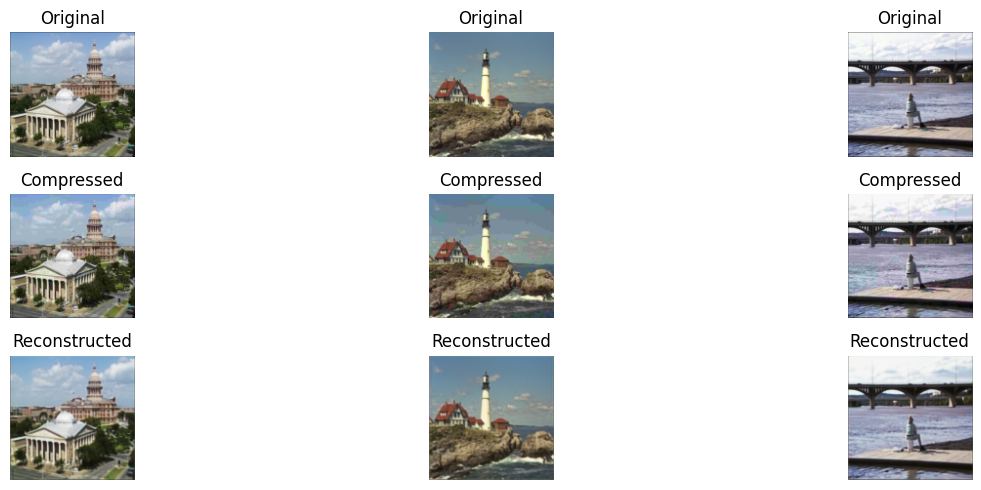

In [9]:

#get the images
o, r, c = reconstructtheimages(model, train_loader, ii = 3)

#make it (plot/visualize)
plots(o, r, c)



In [10]:

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def calculate_metrics(o, r):

    o = np.clip(o, 0, 1)  # did it already but still double check - do again
    r = np.clip(r, 0, 1)
    psnr_values = []
    ssim_values = []

    for orig, recon in zip(o, r):
        # pixels are in 255 so doing it 0 - 255
        orig = (orig * 255).astype(np.uint8)
        recon = (recon * 255).astype(np.uint8)
        psnr_value = psnr(orig, recon, data_range=255) # quality of image
        ssim_value = ssim(orig, recon, multichannel=True, data_range=255, win_size=3) # structural similarity
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    return np.mean(psnr_values), np.mean(ssim_values)



original - output

In [11]:

orr, re , comp = reconstructtheimages(model, train_loader, ii=4)


mean_psnr, mean_ssim = calculate_metrics(orr, re)

print(f'Mean PSNR: {mean_psnr:.4f} dB')
print(f'Mean SSIM: {mean_ssim:.4f}')


Mean PSNR: 34.5128 dB
Mean SSIM: 0.9638


compressed - output

In [12]:

orr, re , comp = reconstructtheimages(model, train_loader, ii=4)


mean_psnr, mean_ssim = calculate_metrics(comp, re)

print(f'Mean PSNR: {mean_psnr:.4f} dB')
print(f'Mean SSIM: {mean_ssim:.4f}')


Mean PSNR: 30.8264 dB
Mean SSIM: 0.9302
